Uncertainty propagation adjusts for noise in RNA velocity vectors
----
Shows how CellRank's uncertainty propagation adjusts for noise in the velocity vectors, produces panels for Extended Data Fig. 3. 

# Preliminaries

## Dependecy notebooks

Additional uncertainty related panels are created in:
- [MK_2020-10-16_uncertainty_sampling.py](MK_2020-10-16_uncertainty_sampling.py)
- [../suppl_fig_robustness/MK_2020-10-16_robustness.ipynb](../suppl_fig_robustness/MK_2020-10-16_robustness.ipynb)

## Import packages

In [1]:
# import standard packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# import single-cell packages
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr

# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [2]:
cr.logging.print_versions()

cellrank==1.5.0+g65f1562 scanpy==1.8.1 anndata==0.7.6 numpy==1.20.3 numba==0.54.0 scipy==1.7.1 pandas==1.3.3 pygpcca==1.0.2 scikit-learn==0.24.2 statsmodels==0.13.0rc0 python-igraph==0.9.1 scvelo==0.2.4 pygam==0.8.0 matplotlib==3.4.3 seaborn==0.11.2


In [3]:
cr.logging.print_version_and_date()

Running CellRank 1.5.0+g65f1562, on 2021-10-26 16:21.


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [4]:
sys.path.insert(0, "../..")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

Set up the paths to save figures.

In [5]:
scv.settings.figdir = str(FIG_DIR)
sc.settings.figdir = str(FIG_DIR)
cr.settings.figdir = str(FIG_DIR)

## Set up caching

Note: we use a caching extension called `scachepy` for this analysis, see [here](https://github.com/theislab/scachepy). We do this to speed up the runtime of this notebook by avoiding the most expensive computations. Below, we check whether you have scachepy installed and if you don't, then we automatically recompute all results. 

In [6]:
try:
    import scachepy
    c = scachepy.Cache(CACHE_DIR / "uncertainty", separate_dirs=True)
except ImportError:
    c = None
    
use_caching = c is not None
c

Cache(root=/Users/marius/Projects/cellrank_reproducibility_2/cache/uncertainty, ext='.pickle', compression='None')

## Set global parameters

Set some plotting parameters.

In [7]:
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')
scv.settings.plot_prefix = ""

Set other global parameters

In [8]:
# should figures just be displayed or also saved?
save_figure = True

# should cashed values be used, or recompute?
force_recompute = False

CellRank specific parameters

In [9]:
# set transition matrix parameters
softmax_scale = None
weight_connectivities = 0.2
seed = 0
n_samples = 50000 # for MC sampling
n_jobs=8

# set estimator parameters
n_states = 9

## Load the data

Load the AnnData object from the CellRank software package. 

In [10]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Use scVelo to compute RNA velocity

## Pre-process the data

In [11]:
# filter, normalise, log transform
scv.pp.filter_and_normalize(adata, min_shared_counts=20, log=True, n_top_genes=2000)

# compute pca, knn graph and scvelo's moments
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:02)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Compute velocities using scVelo

In [13]:
# compute/load from cache the dyn. model params and compute velocities
if use_caching:
    c.tl.recover_dynamics(adata, fname='2020-10-17_recover_dynamics', force=force_recompute)
else:
    scv.tl.recover_dynamics(adata)
    
scv.tl.velocity(adata, mode='dynamical')

Loading data from: `2020-10-17_recover_dynamics.pickle`.
`adata.uns` already contains key: `'recover_dynamics'`.
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Project velocities onto the embedding

Show umap projected velocities:

computing velocity graph (using 1/8 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/edf_uncertainty/umap_velocities.pdf


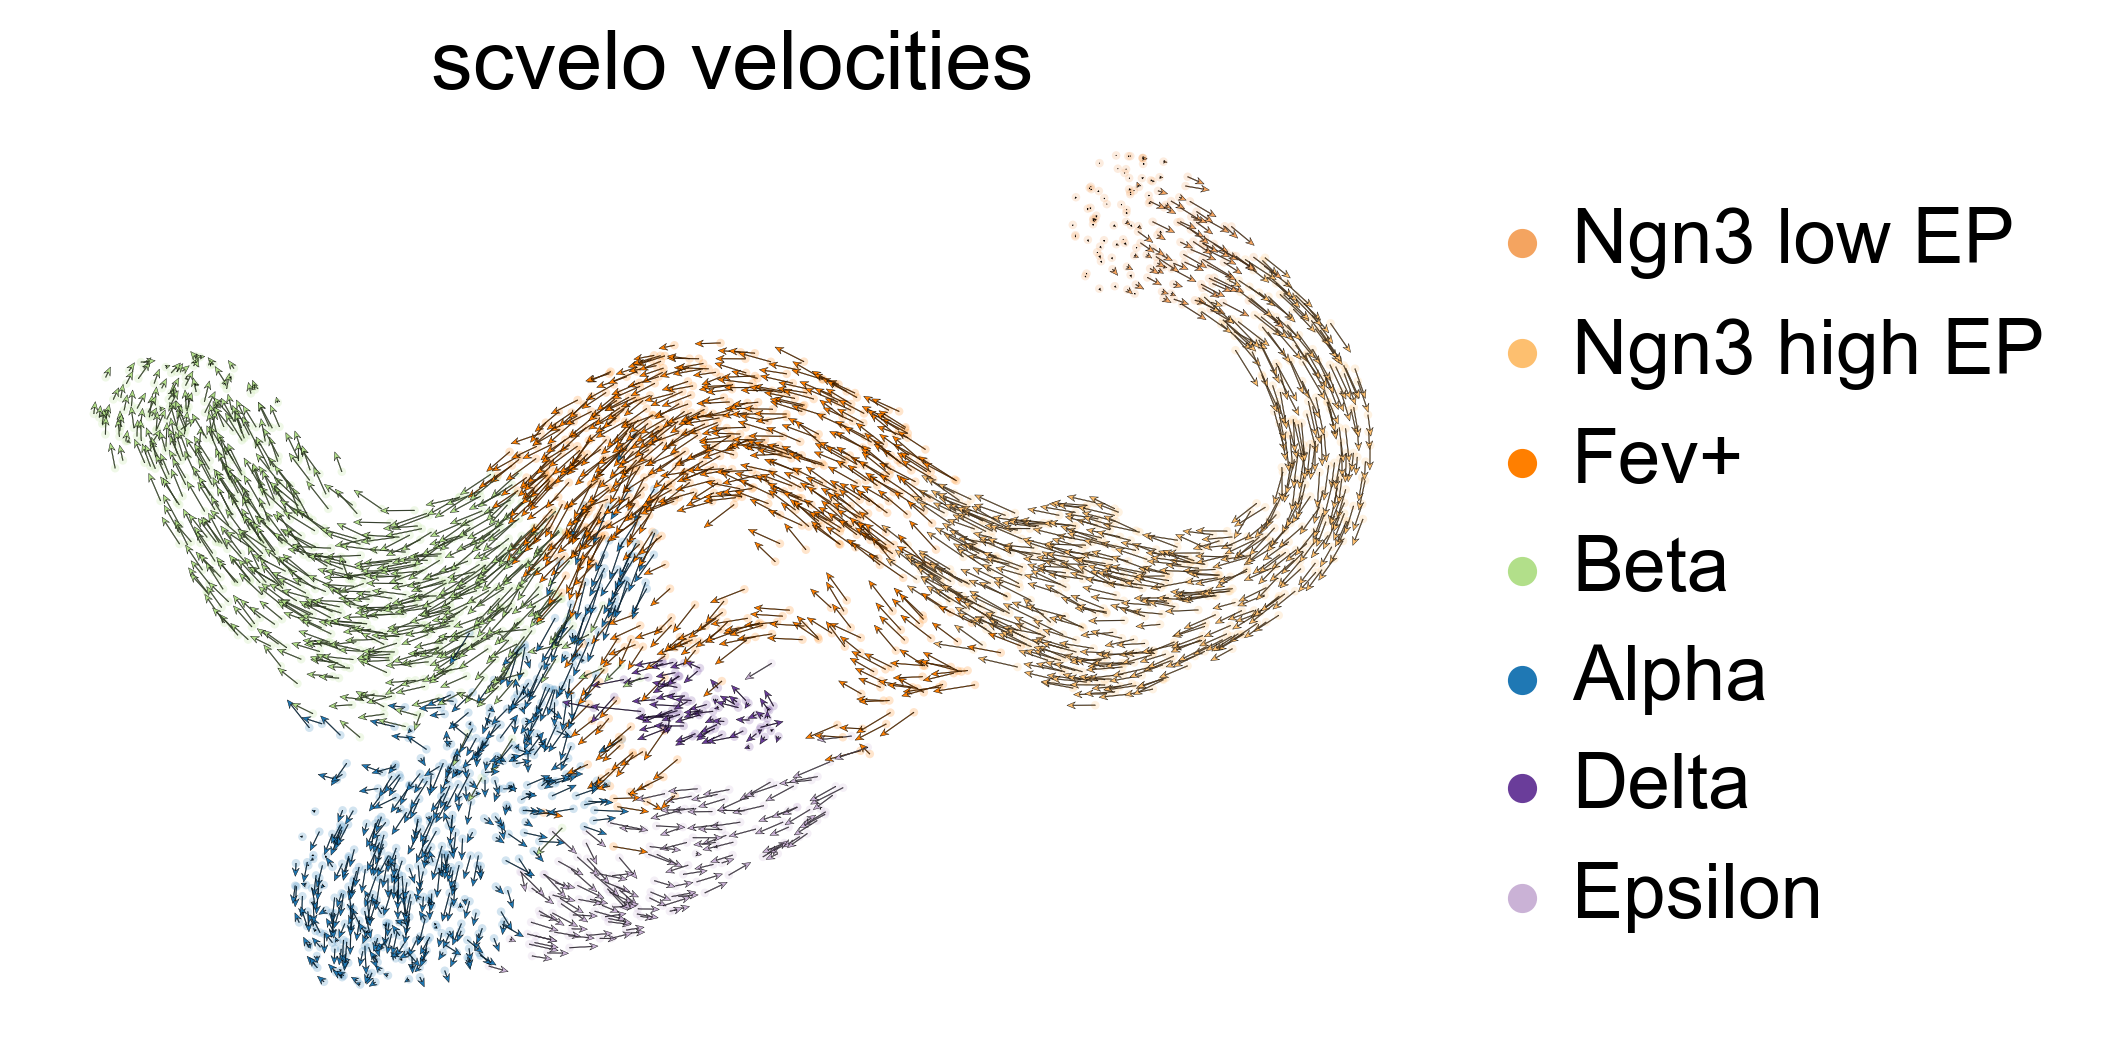

In [15]:
scv.tl.velocity_graph(adata)

fig_kwargs = {'color': ['clusters'], 'title': f'scvelo velocities',
                 'legend_loc': 'right', 'dpi': 150, 'scale': 0.1,}

if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'edf_uncertainty/umap_velocities.pdf'
scv.pl.velocity_embedding(adata, **fig_kwargs)

# Use CellRank to compute transition matrices

## Initialise kernel and estimator

Compute transition probabilities in three different ways:
- deterministic approach
- sampling, Monte Carlo
- analytical, JAX

We cache the transition matrices becasue expecially for the MC mode, this can take a little while. 

In [16]:
from cellrank.tl.kernels import PrecomputedKernel

if use_caching:
    # deterministic transition matrix
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode='deterministic', 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2020-10-17_transition_matrix_det', 
                           force=force_recompute)
    ker_det = PrecomputedKernel(adata.obsp['T_fwd'], adata)
    
    # monte-carlo 
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode='monte_carlo', 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale,
                           seed=seed,
                           n_samples=n_samples,
                           fname='2020-10-17_transition_matrix_mc', 
                           force=force_recompute)
    ker_mc = PrecomputedKernel(adata.obsp['T_fwd'], adata)
    
    # stochastic approximation (jax)
    c.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode='stochastic', 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale, 
                           fname='2020-10-17_transition_matrix_jax', 
                           force=force_recompute)
    ker_jax = PrecomputedKernel(adata.obsp['T_fwd'], adata)
    
else:
    # deterministic transition matrix
    ker_det = cr.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode='deterministic', 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale)
    
    # monte-carlo 
    ker_mc = cr.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode='monte_carlo', 
                           n_jobs=n_jobs,
                           seed=seed,
                           n_samples=n_samples,
                           softmax_scale=softmax_scale)
    
    # stochastic approximation (jax)
    ker_jax = cr.tl.transition_matrix(adata, 
                           weight_connectivities=weight_connectivities, 
                           mode='stochastic', 
                           n_jobs=n_jobs, 
                           softmax_scale=softmax_scale)

Loading data from: `2020-10-17_transition_matrix_det.pickle`.
Loading data from: `2020-10-17_transition_matrix_mc.pickle`.
`adata.obsp` already contains key: `'T_fwd'`.
`adata.uns` already contains key: `'T_fwd_params'`.
Loading data from: `2020-10-17_transition_matrix_jax.pickle`.
`adata.obsp` already contains key: `'T_fwd'`.
`adata.uns` already contains key: `'T_fwd_params'`.


## Print transition matrix statistics for reproducibility

To make sure that we're using the same transition matrix, show some stats. 

In [17]:
# deterministic
T = ker_det.transition_matrix
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.017933,
mean = 0.024591,
var = 0.000510,
min = 0.000051,
max = 0.347959


In [18]:
# monte carlo
T = ker_mc.transition_matrix
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.019147,
mean = 0.024591,
var = 0.000433,
min = 0.000187,
max = 0.398694


In [20]:
# stochastic analytical with jax
T = ker_jax.transition_matrix
T_med, T_mean, T_var = np.median(T.data), np.mean(T.data), np.var(T.data)
T_min, T_max = np.min(T.data), np.max(T.data)

print(f'med = {T_med:.6f},\nmean = {T_mean:.6f},\nvar = {T_var:.6f},\nmin = {T_min:.6f},\nmax = {T_max:.6f}')

med = 0.018982,
mean = 0.024591,
var = 0.000451,
min = 0.000067,
max = 0.408090


# Look at high and low noise regions

## Select representative cells

We select one early cell where velocity vectors tend to point into the same direction and one cell from a decision region where velocity vectors are very noisy. 

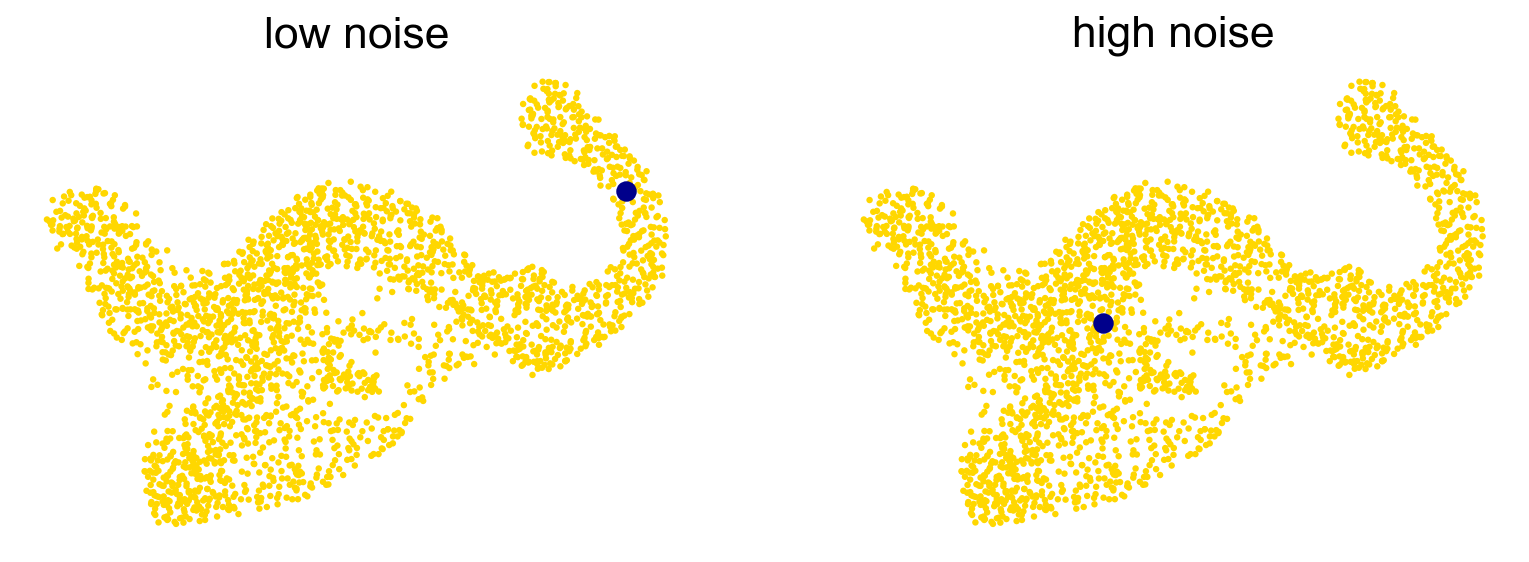

In [21]:
sample_cells = {'low_noise': 110, 'high_noise': 1}
scv.pl.scatter(adata, color=[ix for ix in sample_cells.values()], 
               title=[key for key in sample_cells.keys()])

## Low noise region

### Show the cell and its nearest neighbors

Let's run one of these at a time. 

In [22]:
reference_ix = sample_cells['low_noise']
nbhs_ixs = adata.obsp['connectivities'][reference_ix, :].indices
n_cells = len(nbhs_ixs)

print(f"This is an {adata[reference_ix].obs['clusters'].values[0]} cell with {n_cells} neighbors. ")

if reference_ix in nbhs_ixs:
    print("Warning, reference is in the neighbors")

This is an Ngn3 high EP cell with 35 neighbors. 


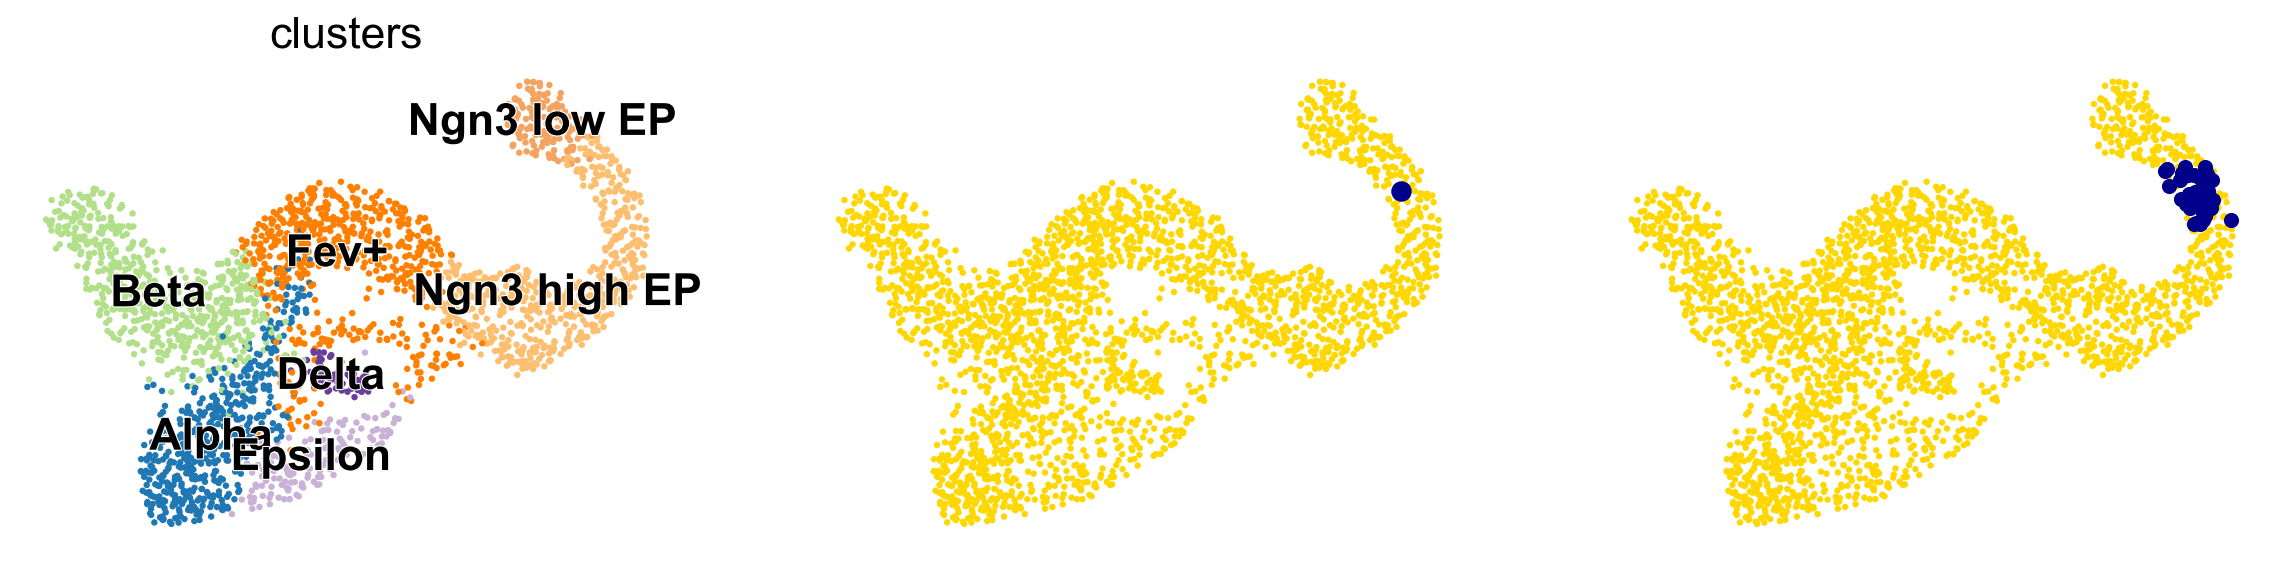

In [23]:
scv.pl.scatter(adata, color=['clusters', reference_ix, nbhs_ixs], legend_loc='on data')

### Show projected velocity vectors

Plot the reference cell with it's neighbors and their velocity vectors

In [24]:
# crete a mask to identify the reference cell
ext = lambda x, y: np.append(x, y)
reference_ix_mask = ext(nbhs_ixs, reference_ix) == reference_ix

# get the coordinates the vectors
umap = adata.obsm['X_umap'][ext(nbhs_ixs, reference_ix), :]
velocity = adata.obsm['velocity_umap'][ext(nbhs_ixs, reference_ix), :]

# create color annotations
color = scv.utils.interpret_colorkey(adata[ext(nbhs_ixs, reference_ix)], c="clusters")

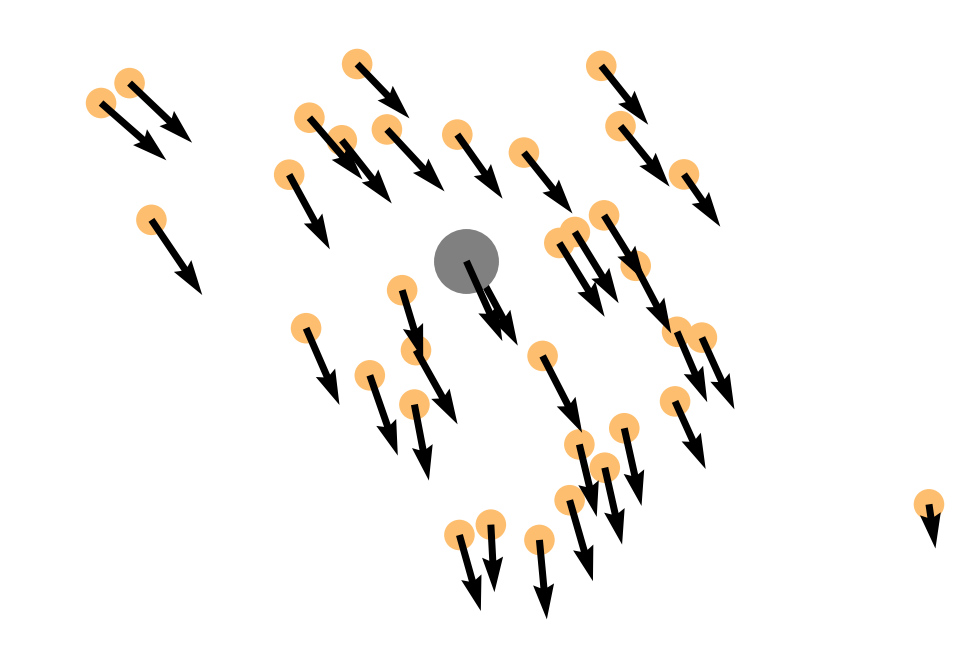

In [25]:
# create a figure 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

# plot all but the reference
ax.scatter(umap[~reference_ix_mask, 0], umap[~reference_ix_mask, 1], c=color[~reference_ix_mask], 
           cmap='viridis', s=100)
ax.quiver(umap[~reference_ix_mask, 0], umap[~reference_ix_mask, 1], 
          velocity[~reference_ix_mask, 0], velocity[~reference_ix_mask, 1], 
          color='k', linewidth = 0.5, scale=0.9)

# plot the reference cell
ax.scatter(umap[reference_ix_mask, 0], umap[reference_ix_mask, 1], c='grey', #c=color[reference_ix_mask], 
           cmap='viridis', s=500)
ax.quiver(umap[reference_ix_mask, 0], umap[reference_ix_mask, 1], 
          velocity[reference_ix_mask, 0], velocity[reference_ix_mask, 1], 
          color='k', linewidth = 0.5, scale=0.8)

# work on the axis
ax.set_xlim(np.min(umap[:, 0]) -0.3, np.max(umap[:, 0]) + 0.1)
ax.set_ylim(np.min(umap[:, 1]) -0.4, np.max(umap[:, 1]) + 0.2)
plt.axis("off")

if save_figure: 
    plt.savefig(FIG_DIR / "edf_uncertainty" / "low_noise_velocities.pdf")

plt.show()

### Visualise transition probabilities

Get the transition probabilities for this cell by using the pre-computed kernel objects:

In [26]:
p_mc = ker_mc.transition_matrix[reference_ix].data
p_jax = ker_jax.transition_matrix[reference_ix].data
p_det = ker_det.transition_matrix[reference_ix].data

Let's look at this at the level of individual transitions

In [27]:
transition_probs_df = pd.DataFrame(data=[range(n_cells), p_det, p_jax, p_mc], 
                                   index=['neighbors', 'deterministic', 'stochastic - analytical', 'stochastic - sampling']).T
transition_probs_df = transition_probs_df.melt(id_vars='neighbors', var_name="mode", 
                                               value_name="transition probability")

Sort and restrict to the top 10 cells

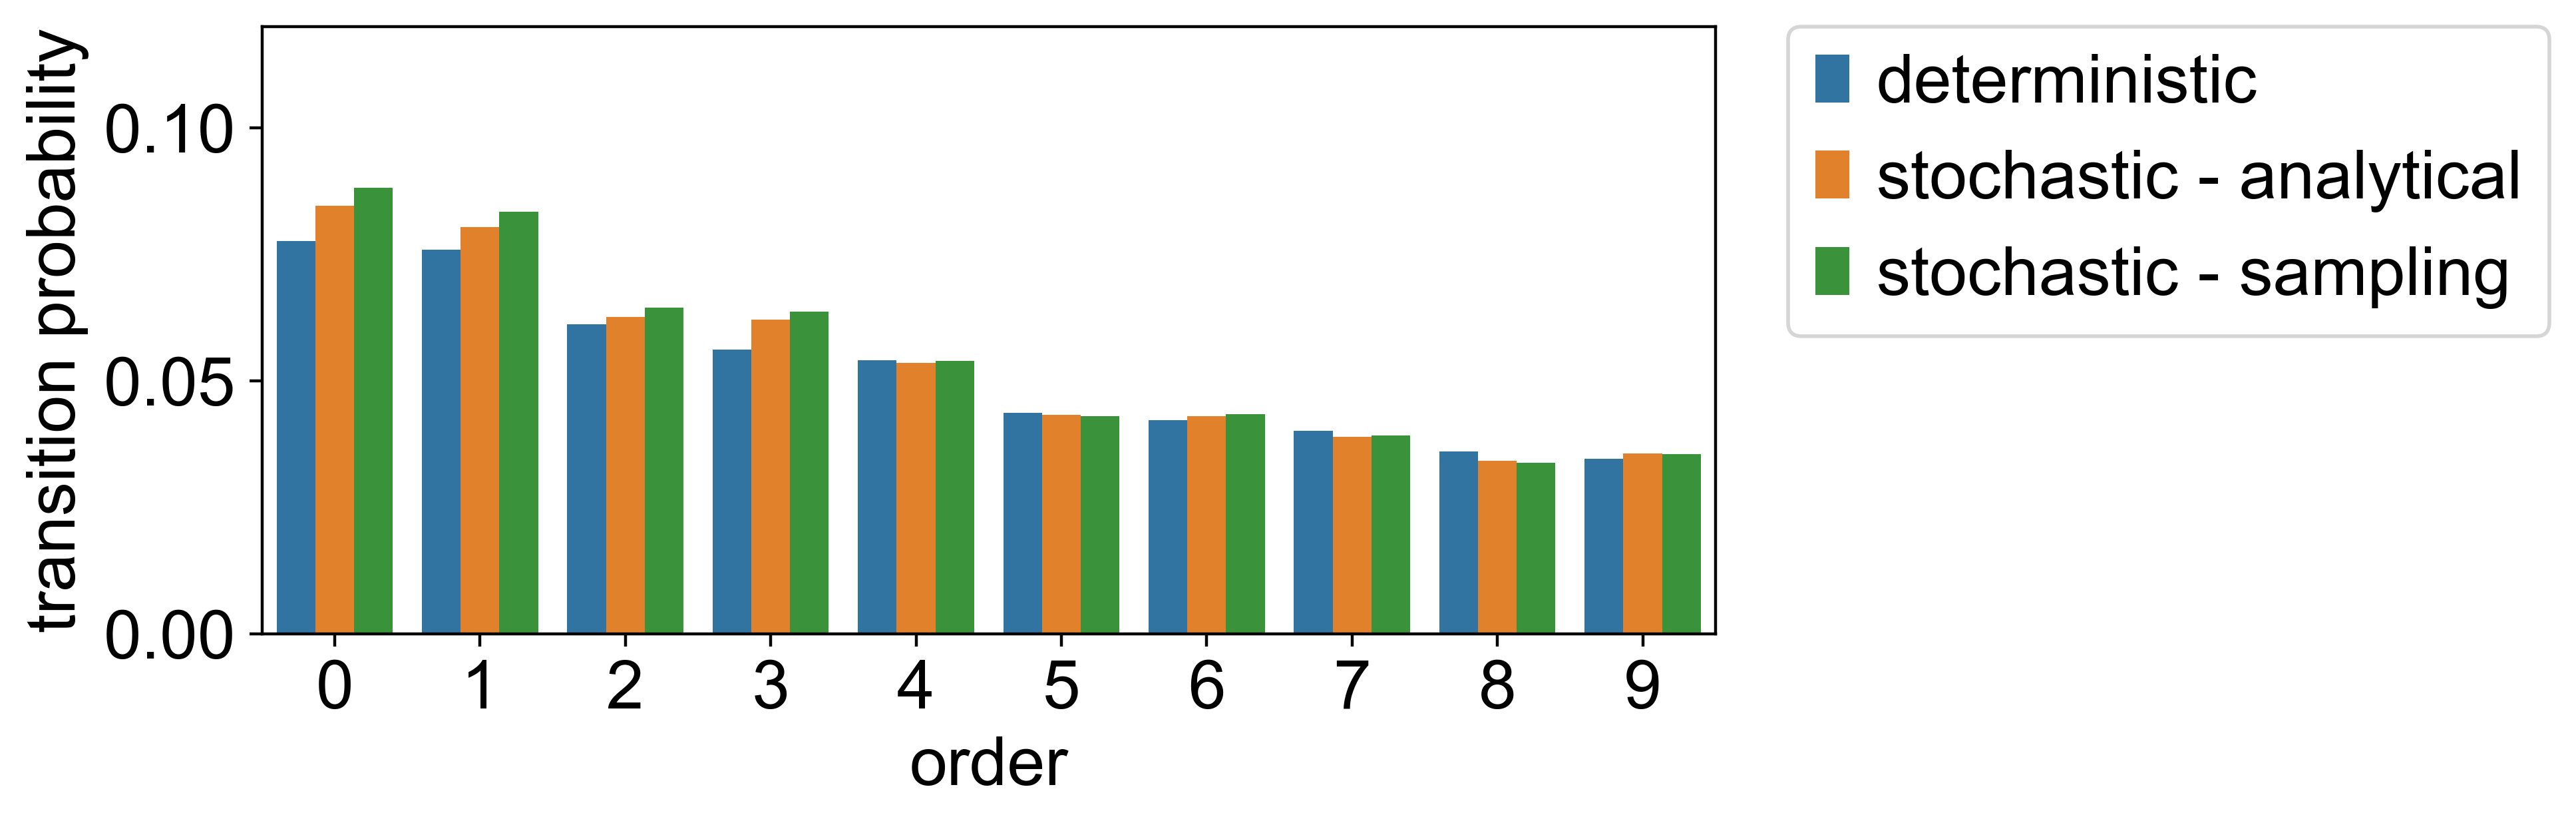

In [28]:
transition_probs_df = pd.DataFrame(data=[p_det, p_jax, p_mc], 
                                   index=['deterministic', 'stochastic - analytical', 'stochastic - sampling']).T
transition_probs_df = transition_probs_df.sort_values(by='deterministic', ascending=False).head(10)
transition_probs_df['order'] = range(transition_probs_df.shape[0])

transition_probs_df = transition_probs_df.melt(id_vars='order', var_name="mode", 
                                               value_name="transition probability")

fig = plt.figure(None, figsize=(7, 3), dpi=200)
ax = fig.add_subplot(111)

ax = sns.barplot(x='order', y="transition probability", hue="mode", data=transition_probs_df, ax=ax)
ax.set_ylim(0, 0.12)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if save_figure:
    plt.savefig(FIG_DIR / "edf_uncertainty" / "low_noise_barplot_trans_probs.pdf")

plt.show()

## High noise region

### Show the cell and its nearest neighbors

Let's run one of these at a time. 

In [29]:
reference_ix = sample_cells['high_noise']
nbhs_ixs = adata.obsp['connectivities'][reference_ix, :].indices
n_cells = len(nbhs_ixs)

print(f"This is an {adata[reference_ix].obs['clusters'].values[0]} cell with {n_cells} neighbors. ")

if reference_ix in nbhs_ixs:
    print("Warning, reference is in the neighbors")

This is an Alpha cell with 33 neighbors. 


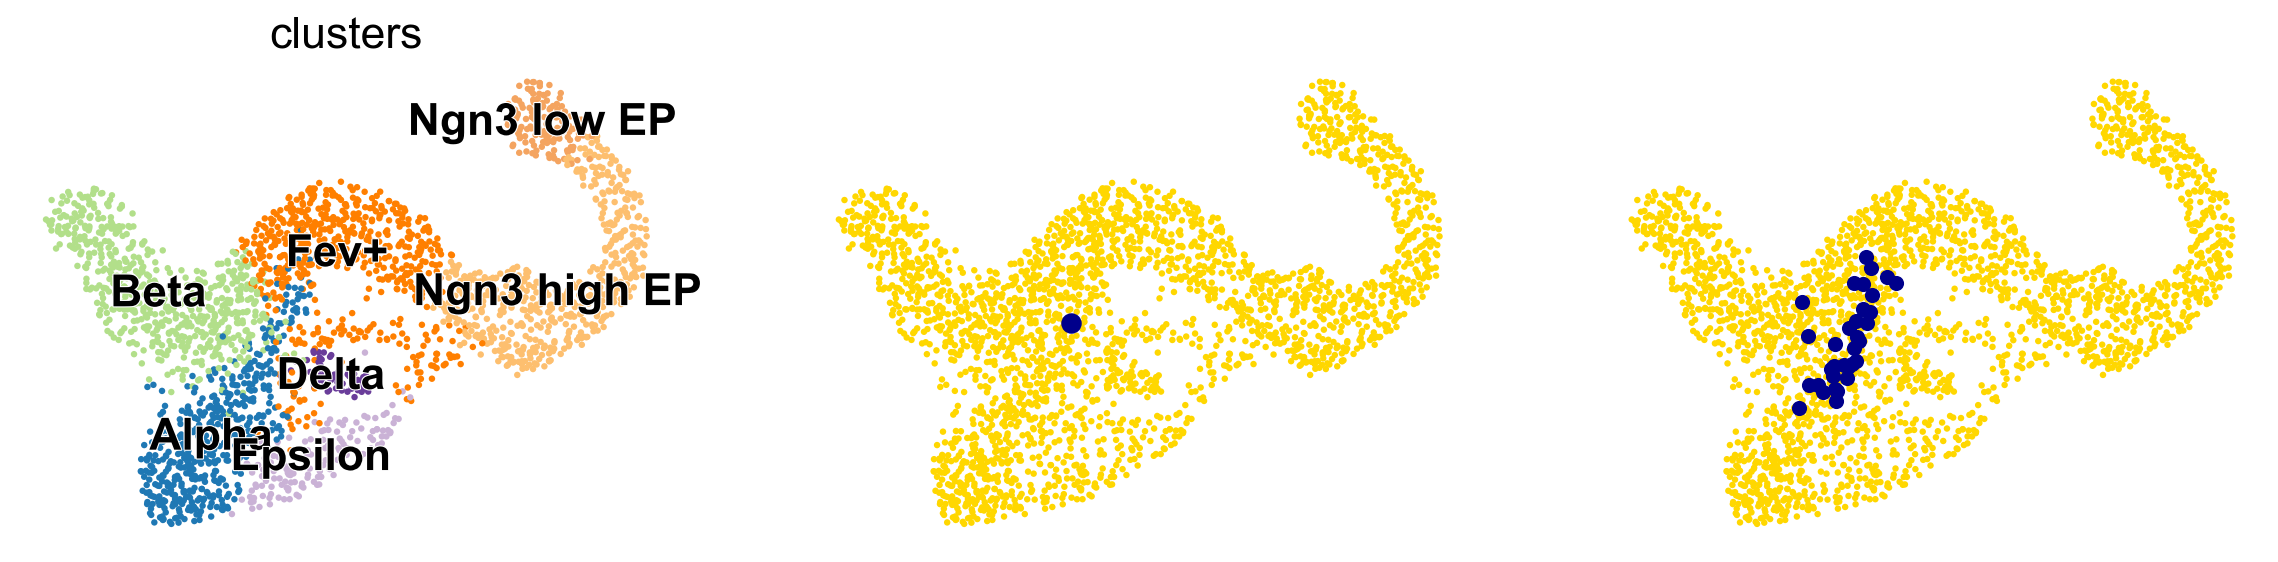

In [30]:
scv.pl.scatter(adata, color=['clusters', reference_ix, nbhs_ixs], legend_loc='on data')

### Show projected velocity vectors

Plot the reference cell with it's neighbors and their velocity vectors

In [31]:
# crete a mask to identify the reference cell
ext = lambda x, y: np.append(x, y)
reference_ix_mask = ext(nbhs_ixs, reference_ix) == reference_ix

# get the coordinates the vectors
umap = adata.obsm['X_umap'][ext(nbhs_ixs, reference_ix), :]
velocity = adata.obsm['velocity_umap'][ext(nbhs_ixs, reference_ix), :]

# create color annotations
color = scv.utils.interpret_colorkey(adata[ext(nbhs_ixs, reference_ix)], c="clusters")

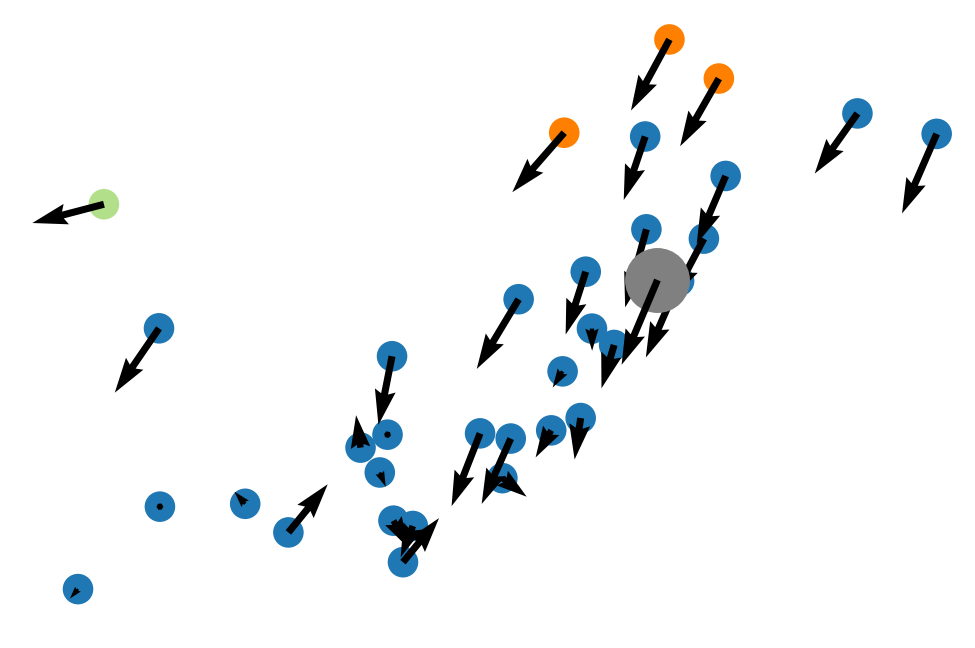

In [32]:
# create a figure 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

# plot all but the reference
ax.scatter(umap[~reference_ix_mask, 0], umap[~reference_ix_mask, 1], c=color[~reference_ix_mask], 
           cmap='viridis', s=100)
ax.quiver(umap[~reference_ix_mask, 0], umap[~reference_ix_mask, 1], 
          velocity[~reference_ix_mask, 0], velocity[~reference_ix_mask, 1], 
          color='k', linewidth = 0.5, scale=0.9)

# plot the reference cell
ax.scatter(umap[reference_ix_mask, 0], umap[reference_ix_mask, 1], c='grey', #c=color[reference_ix_mask], 
           cmap='viridis', s=500)
ax.quiver(umap[reference_ix_mask, 0], umap[reference_ix_mask, 1], 
          velocity[reference_ix_mask, 0], velocity[reference_ix_mask, 1], 
          color='k', linewidth = 0.5, scale=0.8)

# work on the axis
ax.set_xlim(np.min(umap[:, 0]) -0.3, np.max(umap[:, 0]) + 0.1)
ax.set_ylim(np.min(umap[:, 1]) -0.4, np.max(umap[:, 1]) + 0.2)
plt.axis("off")

if save_figure: 
    plt.savefig(FIG_DIR / "edf_uncertainty" / "high_noise_velocities.pdf")

plt.show()

### Visualise transition probabilities

Get the transition probabilities for this cell by using the pre-computed kernel objects:

In [33]:
p_mc = ker_mc.transition_matrix[reference_ix].data
p_jax = ker_jax.transition_matrix[reference_ix].data
p_det = ker_det.transition_matrix[reference_ix].data

Let's look at this at the level of individual transitions

In [34]:
transition_probs_df = pd.DataFrame(data=[range(n_cells), p_det, p_jax, p_mc], 
                                   index=['neighbors', 'deterministic', 'stochastic - analytical', 'stochastic - sampling']).T
transition_probs_df = transition_probs_df.melt(id_vars='neighbors', var_name="mode", 
                                               value_name="transition probability")

Sort and restrict to the top 10 cells

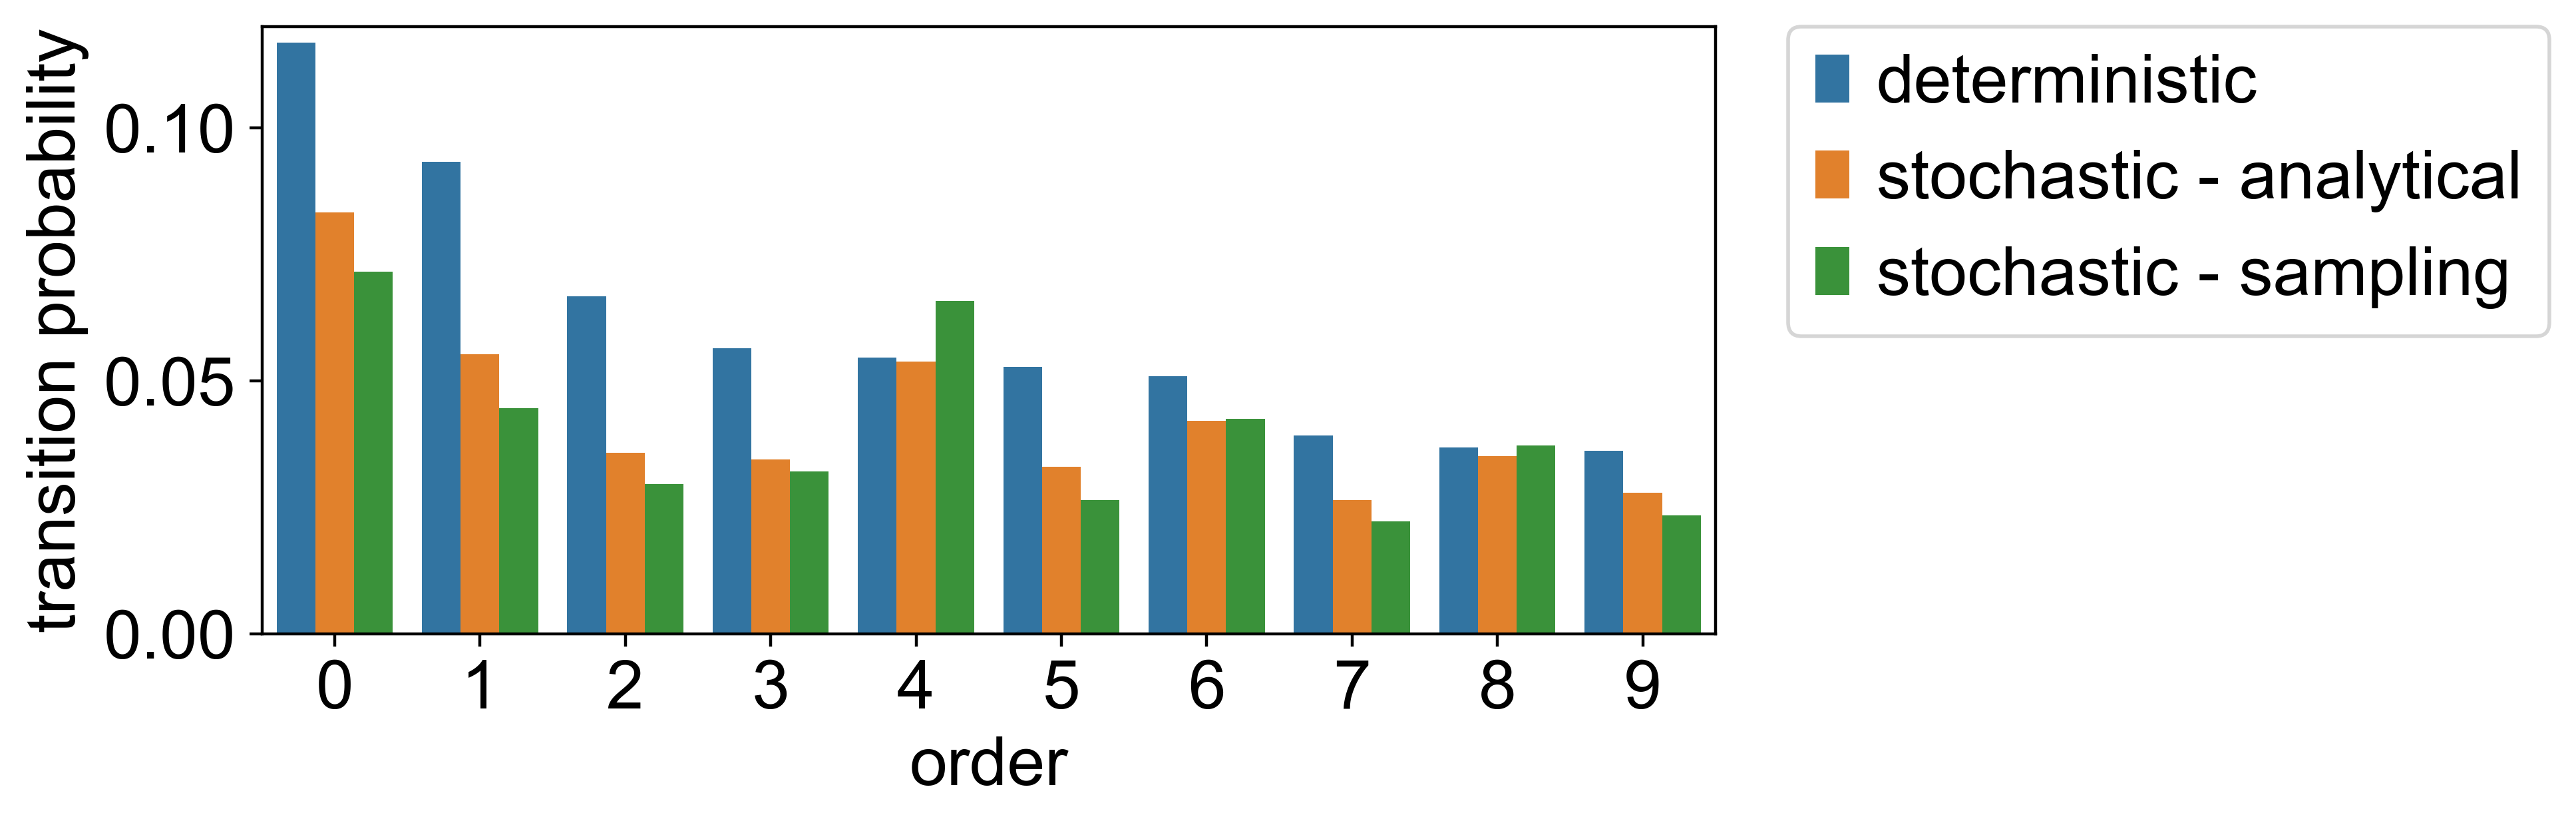

In [35]:
transition_probs_df = pd.DataFrame(data=[p_det, p_jax, p_mc], 
                                   index=['deterministic', 'stochastic - analytical', 'stochastic - sampling']).T
transition_probs_df = transition_probs_df.sort_values(by='deterministic', ascending=False).head(10)
transition_probs_df['order'] = range(transition_probs_df.shape[0])

transition_probs_df = transition_probs_df.melt(id_vars='order', var_name="mode", 
                                               value_name="transition probability")

fig = plt.figure(None, figsize=(7, 3), dpi=200)
ax = fig.add_subplot(111)

ax = sns.barplot(x='order', y="transition probability", hue="mode", data=transition_probs_df, ax=ax)
ax.set_ylim(0, 0.12)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

if save_figure:
    plt.savefig(FIG_DIR / "edf_uncertainty" / "high_noise_barplot_trans_probs.pdf")

plt.show()

# Aggregate to all cells - show absorption probs

## Initialise estimators

Initialise GPCCA estimator objects based on the transition matrices we computed above. 

In [36]:
from cellrank.tl.estimators import GPCCA

g_det = GPCCA(ker_det)
g_jax = GPCCA(ker_jax)

print(g_det)
print(g_jax)

GPCCA[n=2531, kernel=<PrecomputedKernel[origin='array']>]
GPCCA[n=2531, kernel=<PrecomputedKernel[origin='array']>]


## Show the subclustering of Fev+ cells

saving figure to file /Users/marius/Projects/cellrank_reproducibility_2/figures/edf_uncertainty/fev+_clusters.pdf


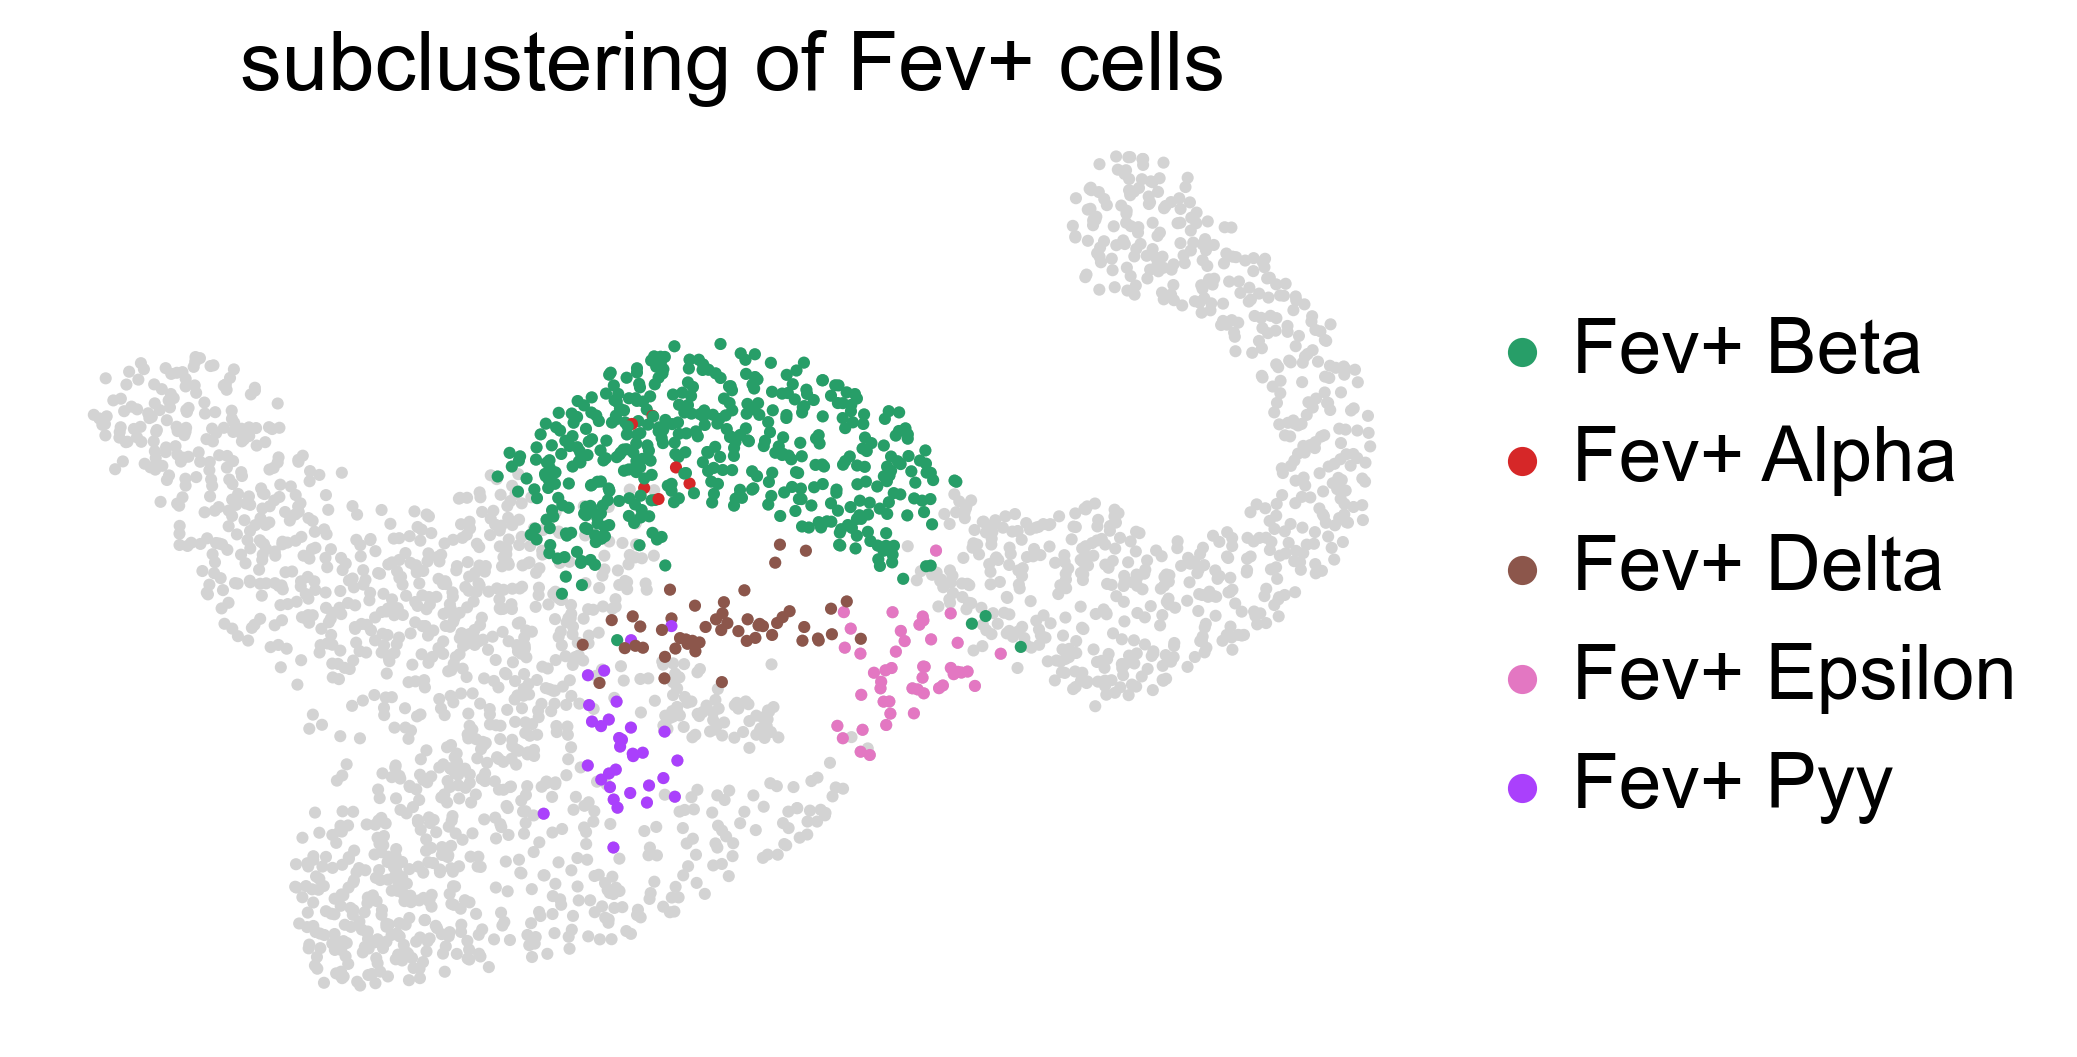

In [38]:
fig_kwargs = {'color': 'clusters_fine', 
                'legend_loc': 'right', 
                'groups': ['Fev+ Beta', 'Fev+ Alpha', 'Fev+ Delta','Fev+ Epsilon', 'Fev+ Pyy'],
                'title': 'subclustering of Fev+ cells', 
                 'dpi': 150,
                }
if save_figure: fig_kwargs['save'] = scv.settings.figdir + 'edf_uncertainty/fev+_clusters.pdf'
scv.pl.scatter(adata, **fig_kwargs)

## Run the deterministic model

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 10]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:01)


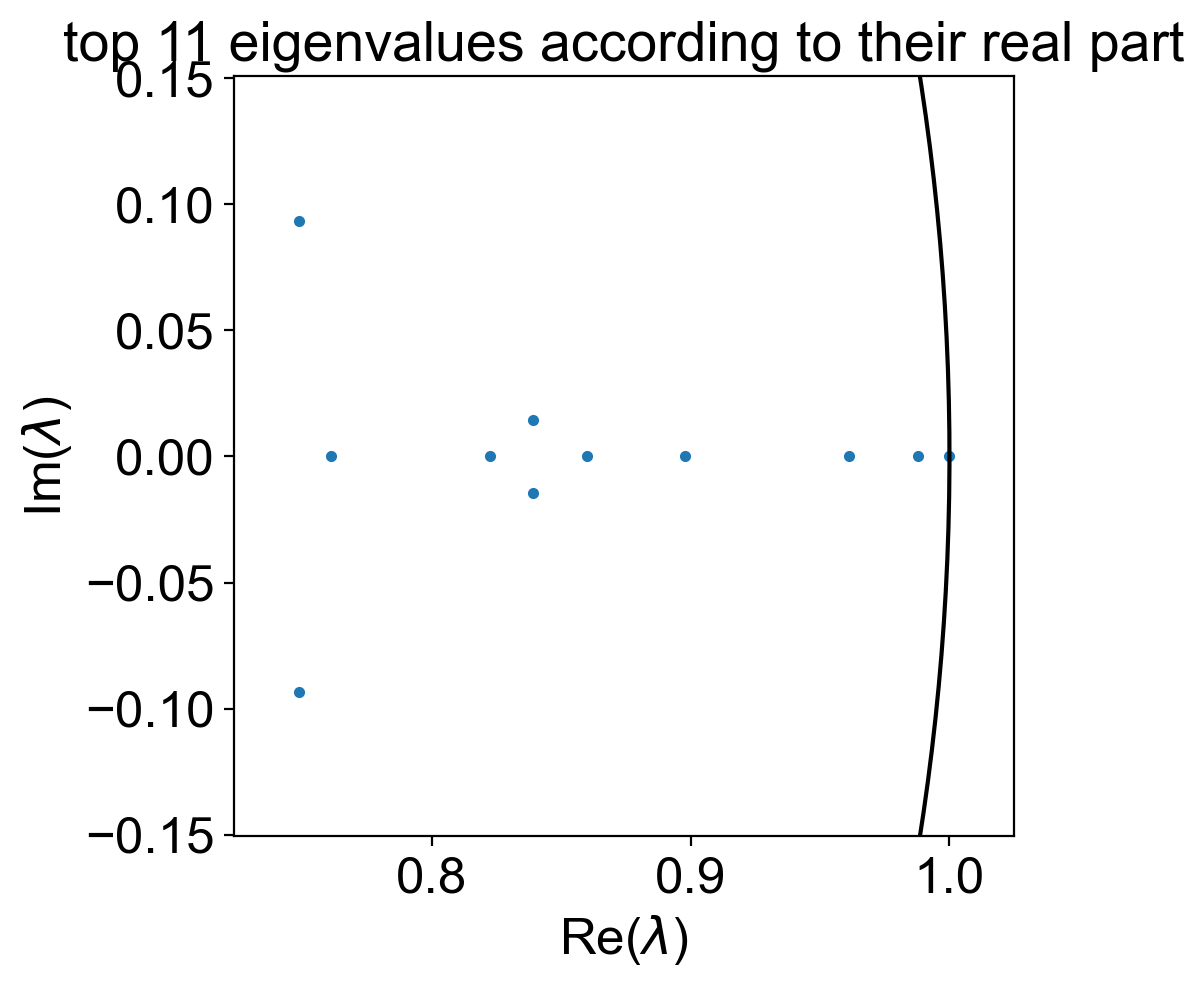

In [39]:
g_det.compute_schur()
g_det.plot_spectrum()

Computing `9` macrostates


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


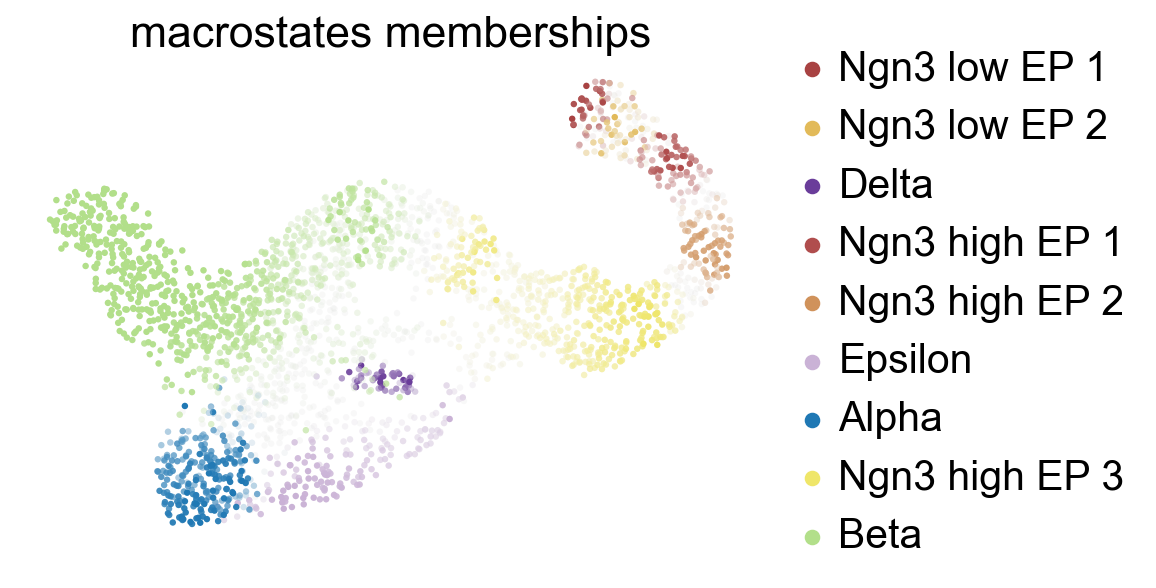

In [41]:
g_det.compute_macrostates(cluster_key='clusters', n_states=n_states)
g_det.plot_macrostates(legend_loc="right")

Automatically determine the terminal states:

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


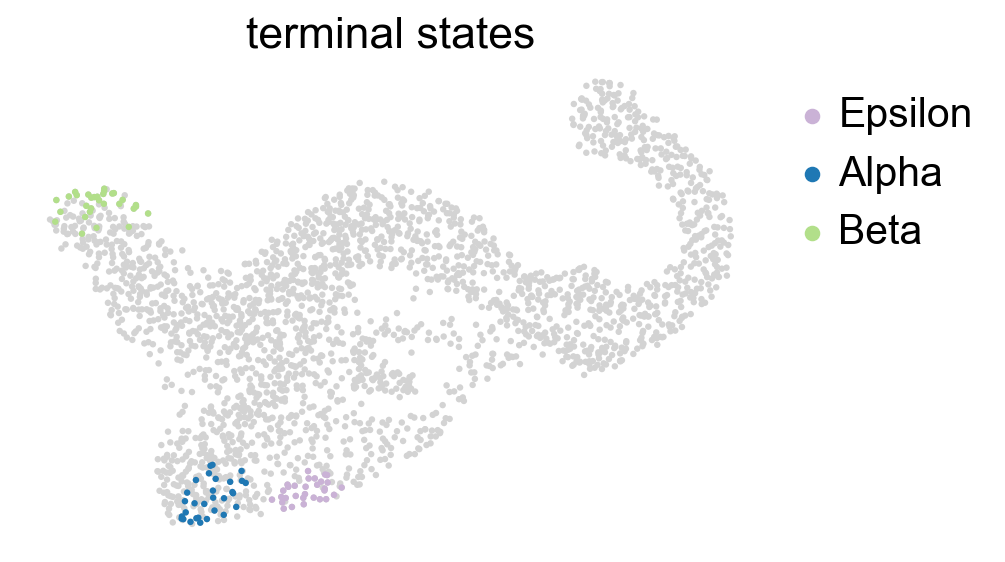

In [42]:
g_det.compute_terminal_states()
scv.pl.scatter(adata, c='terminal_states')

Add the Delta state manually:

In [43]:
g_det.set_terminal_states_from_macrostates(names=['Alpha', 'Beta', 'Epsilon', 'Delta'])

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


Compute fate probabilities towards the terminal states:

Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


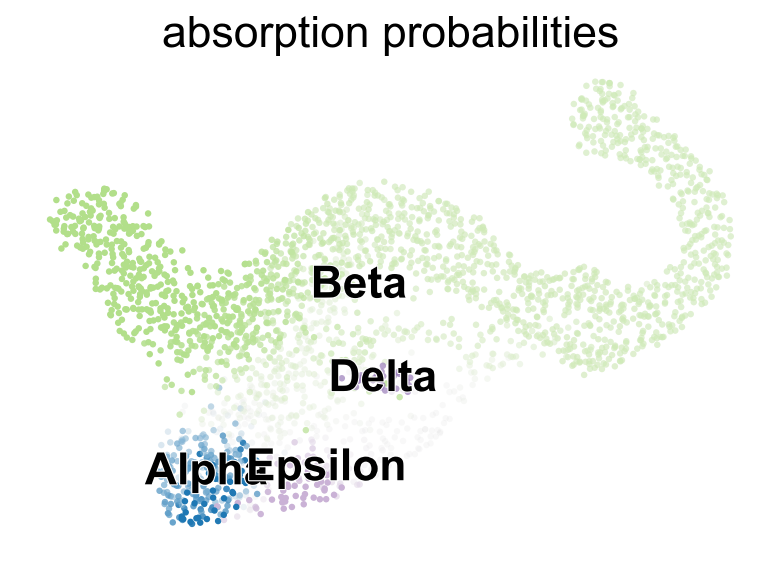

In [44]:
g_det.compute_absorption_probabilities()
g_det.plot_absorption_probabilities()

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


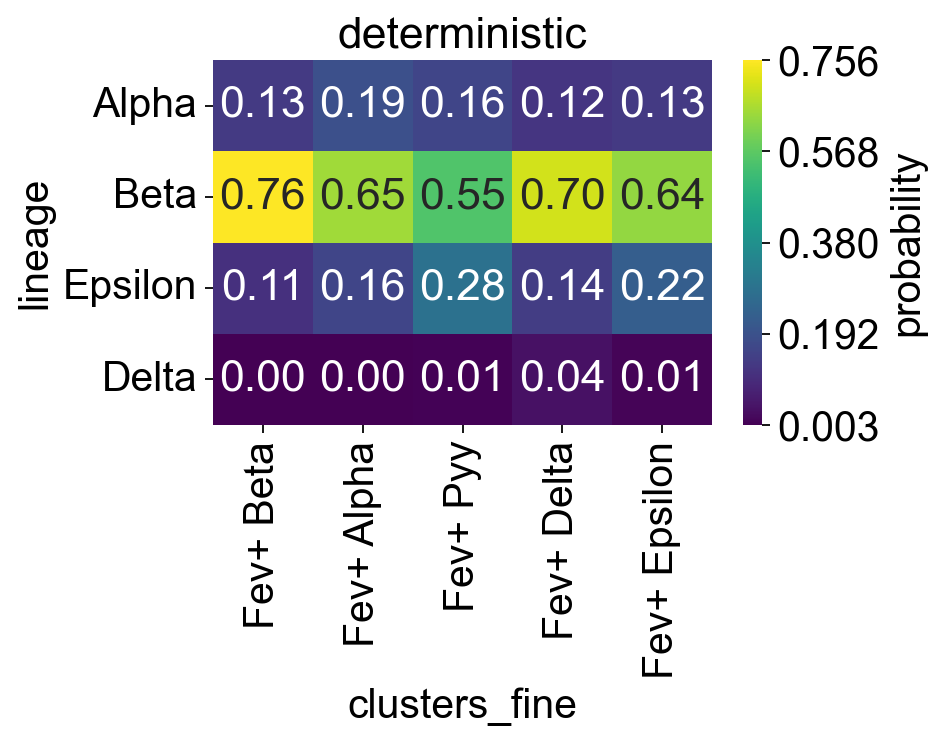

In [45]:
clusters = ['Fev+ Beta', 'Fev+ Alpha', 'Fev+ Pyy','Fev+ Delta', 'Fev+ Epsilon']

fig_kwargs = {'title': 'deterministic', 
              'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
              'cluster_key': 'clusters_fine',
              'clusters': clusters,
              'figsize': (5, 3)}

if save_figure: fig_kwargs['save'] = 'suppl_fig_uncertainty/det_heatmap_fev+.pdf'
cr.pl.cluster_fates(adata, mode='heatmap', **fig_kwargs)

## Run the stochastic analytical model

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 9]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


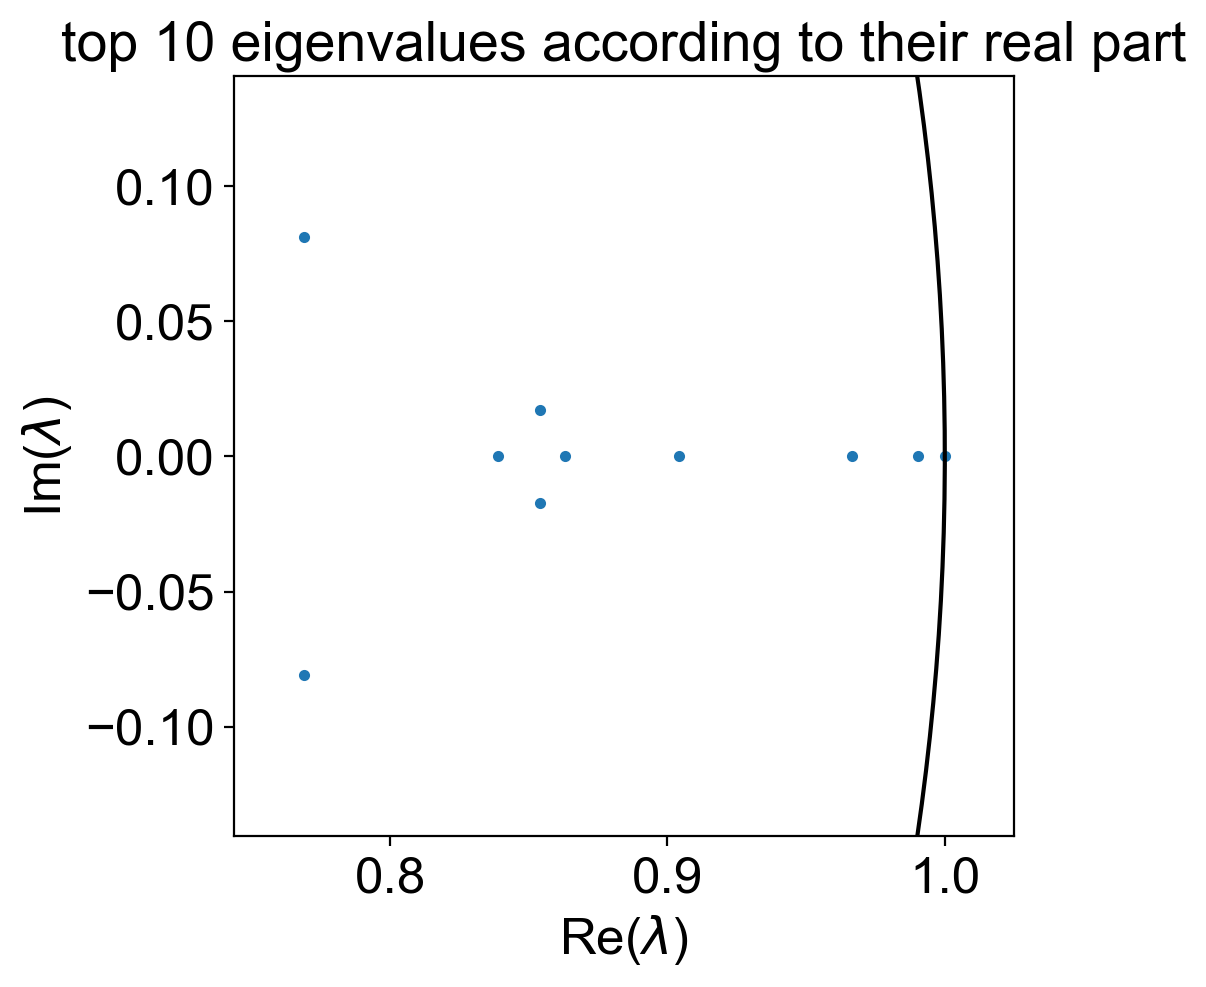

In [46]:
g_jax.compute_schur()
g_jax.plot_spectrum()

Computing `10` macrostates


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:03)


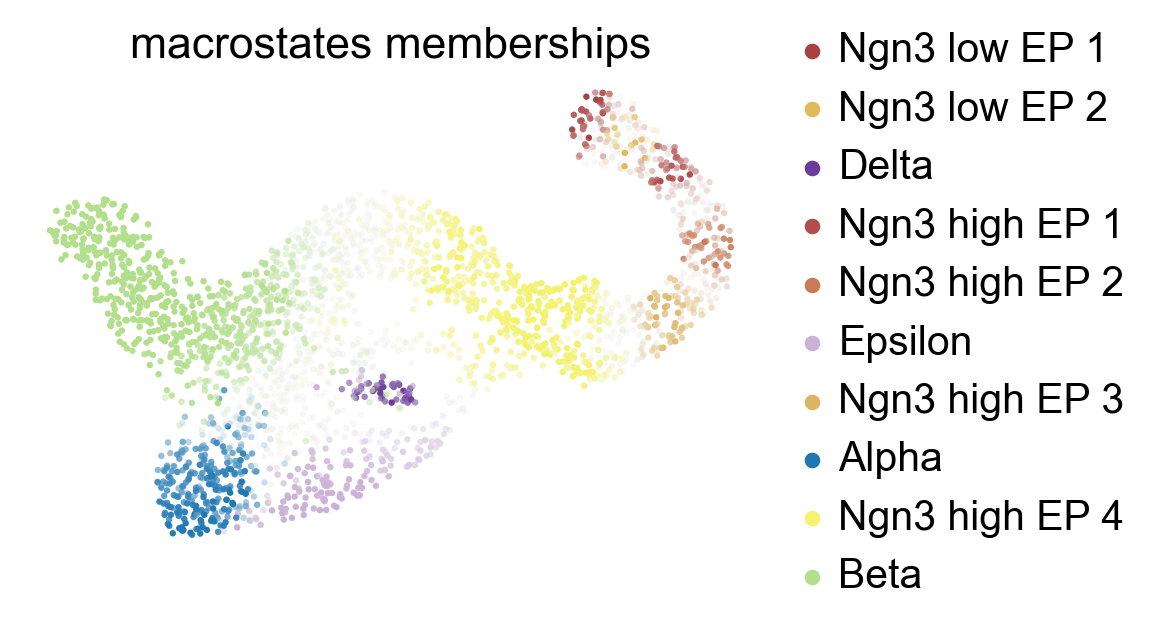

In [47]:
g_jax.compute_macrostates(cluster_key='clusters', n_states=n_states)
g_jax.plot_macrostates(legend_loc="right")

Automatically determine the terminal states:

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


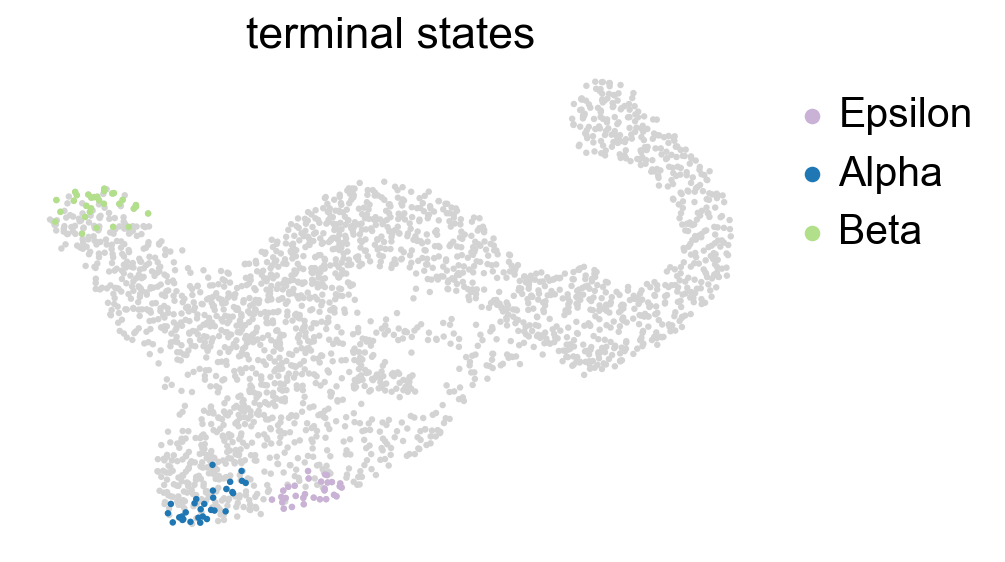

In [48]:
g_jax.compute_terminal_states()
scv.pl.scatter(adata, c='terminal_states')

Manually add the Delta state:

In [49]:
g_jax.set_terminal_states_from_macrostates(names=['Alpha', 'Beta', 'Epsilon', 'Delta'])

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


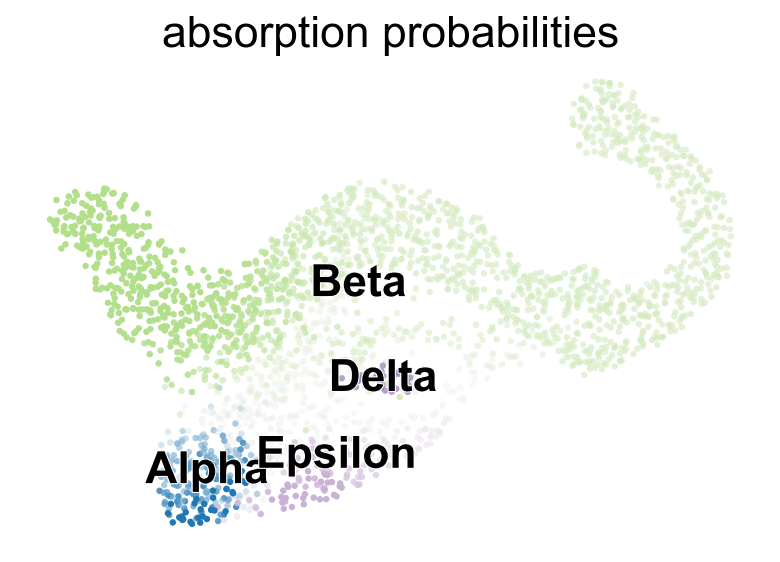

In [50]:
g_jax.compute_absorption_probabilities()
g_jax.plot_absorption_probabilities()

/Users/marius/miniconda3/envs/cellrank/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


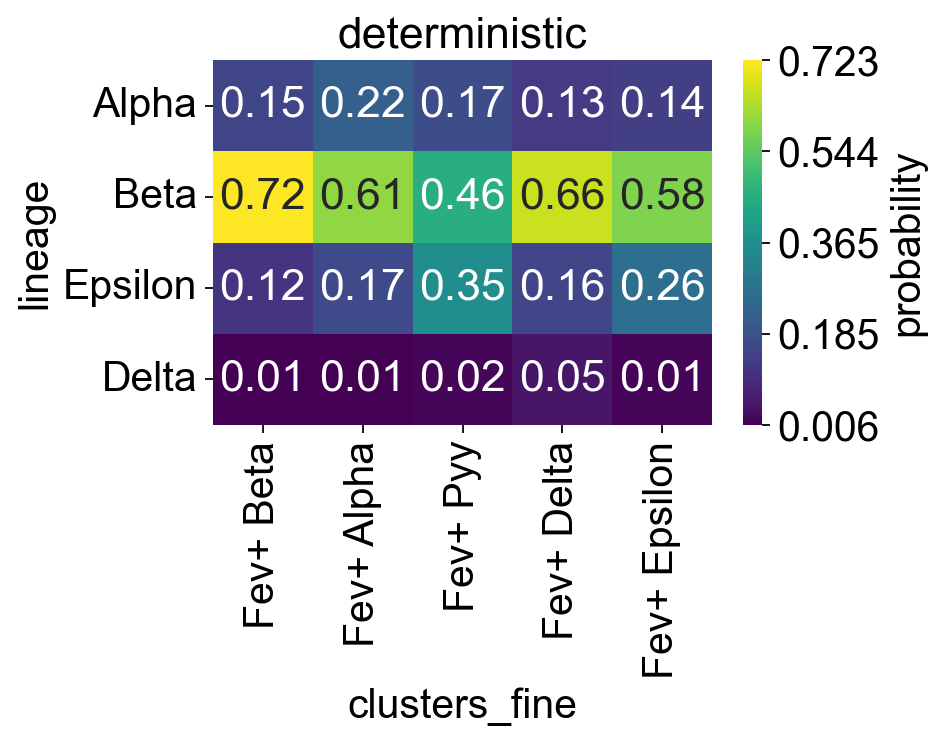

In [51]:
clusters = ['Fev+ Beta', 'Fev+ Alpha', 'Fev+ Pyy','Fev+ Delta', 'Fev+ Epsilon']

fig_kwargs = {'title': 'deterministic', 
              'lineages': ['Alpha', 'Beta', 'Epsilon', 'Delta'],
              'cluster_key': 'clusters_fine',
              'clusters': clusters,
              'figsize': (5, 3)}

if save_figure: fig_kwargs['save'] = 'suppl_fig_uncertainty/jax_heatmap_fev+.pdf'
cr.pl.cluster_fates(adata, mode='heatmap', **fig_kwargs)

## Run the stochastic (sampling) model

This is computationally quite expensive, so we decided to do this in a separate notebook, which you find here [MK_2020-10-16_uncertainty_sampling.py](MK_2020-10-16_uncertainty_sampling.py).

# Robustness comparison

This is in the following notebook: [../suppl_fig_robustness/MK_2020-10-16_robustness.ipynb](../suppl_fig_robustness/MK_2020-10-16_robustness.ipynb)